In [1]:
import numpy as np
import pandas as pd
import pickle
# SQL related packages
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
# sklearn packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression as Log
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
# text analysis packages
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from collections import Counter
from nltk.stem.porter import PorterStemmer

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# access to sql database
dbname = 'patent_db'
username = 'jy'
pswd = 'jy'

engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

# reading from sql database
# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

#### Extract abstracts first

In [3]:
# read data from 2004-2007
years = np.arange(2004, 2008)

# dataframe to store the results
abstracts = pd.DataFrame()

# import the abstract from each table
for year in years:
    # query:
    sql_query = """
    SELECT abstract, id, payment_times
        FROM patents_%s;
    """ %str(year)

    results = pd.read_sql_query(sql_query,con)
    
    abstracts = pd.concat([abstracts, results], axis = 0)
    
# check size of the data
abstracts.shape

(12033, 3)

In [4]:
# extract the response variable
# reformat the response variable into binary
y_data = np.zeros(abstracts.shape[0])
y_data[abstracts['payment_times'].values >= 2] = 1

print "Percentage of patents with > 1 maintenance fee payments: ", np.mean(y_data)

Percentage of patents with > 1 maintenance fee payments:  0.628521565694


#### Tokenization and cleaning

In [5]:
def tokenize_cleaning(text):
    # tokenize the text first
    tokens = word_tokenize(text.decode('utf-8'))
    
    # lowercase all the words
    tokens = [w.lower() for w in tokens]
    
    # clean up stop words and punctuations 
    stop_list = stopwords.words('english') + list(string.punctuation)

    tokens_no_stop = [token for token in tokens
                        if token not in stop_list]
    
    # extract stem of the words
    stemmer = PorterStemmer()
    tokens_stem = [stemmer.stem(token) for token in tokens_no_stop]
    
    return tokens_no_stop

In [6]:
# tokenize_clean the abstracts and count the occurence of the words

cleaned_text = []
for i in range(abstracts.shape[0]):
    tokens = tokenize_cleaning(abstracts['abstract'].iloc[i])
    cleaned_text.append(' '.join(word for word in tokens))

In [7]:
# convert to bag-of-words
# min number selected by examine the 'number' words
vectorizer = CountVectorizer(max_df = 0.5, min_df=90)

# performe a count-based vectorization of the document
word_vec = vectorizer.fit(cleaned_text)
word_counts = word_vec.transform(cleaned_text)

word_counts = word_counts.toarray()

In [8]:
word_counts.shape

(12033, 1023)

(array([ 925.,   63.,   19.,    9.,    2.,    2.,    1.,    1.,    0.,    1.]),
 array([   92. ,   913.9,  1735.8,  2557.7,  3379.6,  4201.5,  5023.4,
         5845.3,  6667.2,  7489.1,  8311. ]),
 <a list of 10 Patch objects>)

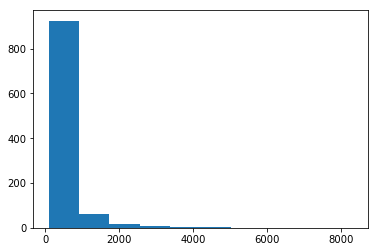

In [9]:
# check the distribution of word occurance
total_counts = np.sum(word_counts, axis = 0)
plt.hist(np.transpose(total_counts))

In [10]:
df = pd.DataFrame({
    'word': word_vec.get_feature_names(),
    'count': total_counts
})

In [11]:
df.iloc[1000:]

,count,word
1000,441,virus
1001,210,vitro
1002,348,vivo
1003,819,voltage
1004,306,volume
1005,399,wall
1006,686,water
1007,334,wave
1008,377,waveguide
1009,459,wavelength


In [115]:
tf_vectorizer = TfidfVectorizer()
tfidf_article = tf_vectorizer.fit_transform(cleaned_text)
tfidf_article = tfidf_article.toarray()

print tfidf_article.shape

(12033, 29829)


#### Spliting train-test data and subsampling

In [28]:
# split train and test sets
x_train, x_test, y_train, y_test = train_test_split(word_counts, y_data, 
                                                    test_size = 0.2, 
                                                    random_state = 123)

print "Dataset dimensions:"
print "x_train: ", x_train.shape
print "x_test: ", x_test.shape
print "y_train: ", y_train.shape
print "y_test: ", y_test.shape

Dataset dimensions:
x_train:  (9626, 1023)
x_test:  (2407, 1023)
y_train:  (9626,)
y_test:  (2407,)


In [29]:
### subsampling the training data
# sample the same number of'useful' patents as the 'not useful' patents
# size of each class
num_size = np.sum(y_train == 0)

#random shuffle the rows
n = x_train.shape[0]
perm = range(n)
np.random.shuffle(perm)

x_train = x_train[perm]
y_train = y_train[perm]

# separate the two classes
x_useful = x_train[y_train == 1, :]
x_not_useful = x_train[y_train == 0, :]
y_useful = y_train[y_train == 1]
y_not_useful = y_train[y_train == 0]

# sample num_size from the 'useful' class
x_useful = x_useful[:num_size]
y_useful = y_useful[:num_size]

# combine the two classes
x_train_sub = np.concatenate((x_useful, x_not_useful), axis = 0)
y_train_sub = np.concatenate((y_useful, y_not_useful), axis = 0)

# shuffle again
# shuffle the combined data
n2 = x_train_sub.shape[0]
perm2 = range(n2)
np.random.shuffle(perm2)

x_train_sub = x_train_sub[perm2]
y_train_sub = y_train_sub[perm2]

# check the size
print x_train_sub.shape
print y_train_sub.shape

(7162, 1023)
(7162,)


In [22]:
# try Naive Bayes with Gaussian Distribution
gnb = GaussianNB()

# fit on the training data
gnb.fit(x_train_sub, y_train_sub)

GaussianNB(priors=None)

In [23]:
# predict on the test data
y_pred = gnb.predict(x_test)

In [121]:
# accuracy
np.mean(y_pred == y_test)

0.49148317407561282

In [24]:
metrics.confusion_matrix(y_test, y_pred)

array([[367, 522],
       [605, 913]])

### PCA

In [123]:
# try dimensionality reduction using PCA
pca = PCA()

x_train_pca = pca.fit_transform(x_train_sub)
x_test_pca = pca.transform(x_test)

In [124]:
# find the cum-variance explained at each level
total_var = np.cumsum(pca.explained_variance_ratio_)
n_pc = np.where((total_var > 0.9) == True)[0][0]

In [125]:
n_pc

3700

In [ ]:
### use logistic regression

# call the model function
model = Log()
# parameter tuning
c =  np.logspace(-5, 5, 11)

# use grid search with 5-fold CV
grid_model = GridSearchCV(model, param_grid = {'C': c}, cv  = 5, scoring = 'accuracy')
# fit on the data
grid_model = grid_model.fit(x_train_pca[:, :n_pc], y_train_sub) 

In [94]:
# check results
print "Best accuracy:", grid_model.best_score_
print "Best parameter: ", grid_model.best_params_

Best accuracy: 0.547691457009
Best parameter:  {'C': 0.001}


In [95]:
# check confusion matrix
best_log = grid_model.best_estimator_
best_log.fit(x_train_pca, y_train_sub)
y_pred = best_log.predict(x_test_pca)

# accuracy
print "Test accuracy: ", np.mean(y_pred == y_test)
print "F1 score: ", metrics.f1_score(y_pred, y_test)
print "Precision: ", metrics.precision_score(y_pred, y_test)
print "Recall: ", metrics.recall_score(y_pred, y_test)
metrics.confusion_matrix(y_test, y_pred)

Test accuracy:  0.524304113004
F1 score:  0.552559593591
Precision:  0.454954954955
Recall:  0.703482587065


array([[555, 298],
       [847, 707]])

In [ ]:
### tune random forest

model = RandomForestClassifier(n_estimators = 100)

# tune max_features
param_space = np.arange(2, 15, 2)

grid_model = GridSearchCV(model, n_jobs = 4, 
                          param_grid = {'max_features': param_space}, 
                          cv  = 5, scoring = 'accuracy')
# fit on the data
# grid_model = grid_model.fit(x_train_pca[:, :n_pc], y_train_sub)
grid_model = grid_model.fit(x_train_sub, y_train_sub)

In [26]:
# check results
print "Best accuracy:", grid_model.best_score_
print "Best parameter: ", grid_model.best_params_

Best accuracy: 0.5048869031
Best parameter:  {'max_features': 12}


In [27]:
# check confusion matrix
best_rf = grid_model.best_estimator_
best_rf.fit(x_train_sub, y_train_sub)
y_pred = best_rf.predict(x_test)

# accuracy
print "Test accuracy: ", np.mean(y_pred == y_test)
print "F1 score: ", metrics.f1_score(y_test, y_pred)
print "Precision: ", metrics.precision_score(y_test, y_pred)
print "Recall: ", metrics.recall_score(y_test, y_pred)
metrics.confusion_matrix(y_test, y_pred)

Test accuracy:  0.495637723307
F1 score:  0.554004408523
Precision:  0.626245847176
Recall:  0.496706192358


array([[439, 450],
       [764, 754]])

Try word2vec, meaning on the document level;
can combine text features with non-text features


## NLP: 
text to number;

### BAG-OF-WORDS approach:
TF-IDF: scale the numbers;
you can hard code some key words as features, otherwise IF-IDF may decrease performance.

**Topic modeling**: only at the document level
Each document is a distribution over topics; each topic is a distribution over terms/words.
Matrix: rows are documents, columns are topics, row sum up to 1.
Topics: matirx as well. But you need to assign topic label to train the model. Need to set the number of topics. 
Basic model: LDA (latent Dirichlet)

### WORD2VEC (word embedding, there is also GLOVE)
Gensin is the library to use!
spxy (harder to learn)
NLTK (not great but easy to use)

continuous bag-of-words, or the other method to predict the word

there are pretrained models on Google news or wikipedia

Can do manual inspection to check the models

features: numbers representing the word/doc meaning 

to documents: take sum or mean as the features

**Doc2vec**: document level, or summarize the key words and do word2vec

shuffle the order of sentenses and train the model again, if corpus is very small. 

can pick up spelling problems.

Gensin takes list of lists

PROCESSES:
smaller corpus requires more preprocessing;
1. split sentenses/words
2. stemming (large documents do not care much)
3. stop words
4. punctuation: ', ", 
5. numbers (no need to remove does not need to touch it)
6. lowercase everything

other features to consider: how long the patent is. it is easier to interpret. 

tSNE is preferred over PCA on text analysis



In [12]:
### subsampling the entire data
# sample the same number of'useful' patents as the 'not useful' patents
# size of each class
num_size = np.sum(y_data == 0)

#random shuffle the rows
n = word_counts.shape[0]
perm = range(n)
np.random.shuffle(perm)

x_data = word_counts[perm]
y_data = y_data[perm]

# separate the two classes
x_useful = x_data[y_data == 1, :]
x_not_useful = x_data[y_data == 0, :]
y_useful = y_data[y_data == 1]
y_not_useful = y_data[y_data == 0]

# sample num_size from the 'useful' class
x_useful = x_useful[:num_size]
y_useful = y_useful[:num_size]

# combine the two classes
x_data_sub = np.concatenate((x_useful, x_not_useful), axis = 0)
y_data_sub = np.concatenate((y_useful, y_not_useful), axis = 0)

# shuffle again
# shuffle the combined data
n2 = x_data_sub.shape[0]
perm2 = range(n2)
np.random.shuffle(perm2)

x_data_sub = x_data_sub[perm2]
y_data_sub = y_data_sub[perm2]

# check the size
print x_data_sub.shape
print y_data_sub.shape

(8940, 1023)
(8940,)


In [13]:
# split train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data_sub, y_data_sub, 
                                                    test_size = 0.2, 
                                                    random_state = 123)

print "Dataset dimensions:"
print "x_train: ", x_train.shape
print "x_test: ", x_test.shape
print "y_train: ", y_train.shape
print "y_test: ", y_test.shape

Dataset dimensions:
x_train:  (7152, 1023)
x_test:  (1788, 1023)
y_train:  (7152,)
y_test:  (1788,)


In [14]:
### tune random forest

model = RandomForestClassifier(n_estimators = 100)

# tune max_features
param_space = np.arange(2, 15, 2)

grid_model = GridSearchCV(model, n_jobs = 4, 
                          param_grid = {'max_features': param_space}, 
                          cv  = 5, scoring = 'accuracy')
# fit on the data
# grid_model = grid_model.fit(x_train_pca[:, :n_pc], y_train_sub)
grid_model = grid_model.fit(x_train, y_train)

In [15]:
# check results
print "Best accuracy:", grid_model.best_score_
print "Best parameter: ", grid_model.best_params_

Best accuracy: 0.574804250559
Best parameter:  {'max_features': 4}


In [16]:
# check confusion matrix
best_rf = grid_model.best_estimator_
best_rf.fit(x_train, y_train)
y_pred = best_rf.predict(x_test)

# accuracy
print "Test accuracy: ", np.mean(y_pred == y_test)
print "F1 score: ", metrics.f1_score(y_test, y_pred)
print "Precision: ", metrics.precision_score(y_test, y_pred)
print "Recall: ", metrics.recall_score(y_test, y_pred)
metrics.confusion_matrix(y_test, y_pred)

Test accuracy:  0.579977628635
F1 score:  0.580681183696
Precision:  0.572057205721
Recall:  0.589569160998


array([[517, 389],
       [362, 520]])